0.3466951847076416


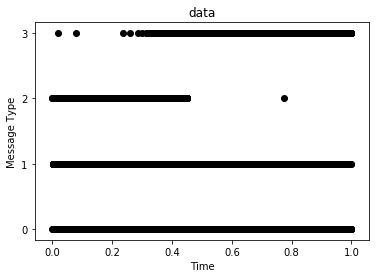

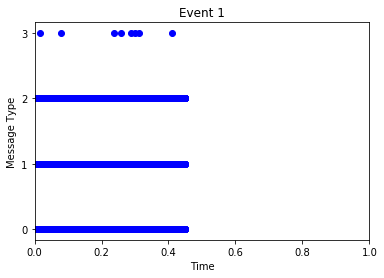

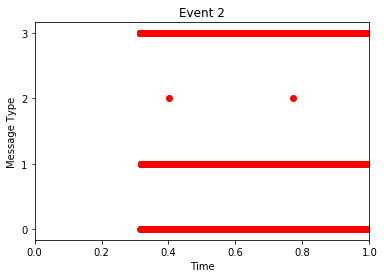

In [36]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 23 16:03:21 2018

@author: ssatpth2
data initialization for CDLDA
"""
import numpy as np
import pandas as pd
import time

def dist(dim,which):
    if which == 'uniform':
        #one distribution is uniform, another is almost uniform with first half epsilon less than uniform and second half epsilon more.
        dim1 = int(np.floor(0.5*dim))
        epsilon = 0.01
        dist1 = np.ones(dim)/dim 
        dist1[:dim1] = dist1[:dim1] - epsilon
        dist1[dim1:] = dist1[dim1:] + epsilon     
        dist1 = dist1/dist1.sum()
        dist2 = np.ones(dim)/dim     
    if which == 'suppdiff':
        #the two distributinos are different by the difference in their support sets
        dim1 = int(np.floor(0.5*dim))
        dim2 = int(np.floor(0.25*dim))
        dist1 = 0.001 + np.hstack( ( 0.5*np.ones(dim1)/dim1, 0.5*np.ones(dim2)/dim2, np.zeros(dim - dim1-dim2)) )
        dist2 = 0.001 + np.hstack( ( 0.5*np.ones(dim1)/dim1, np.zeros(dim2), 0.5*np.ones(dim - dim1-dim2)/(dim - dim1-dim2) ) )
        dist1 = dist1/dist1.sum()
        dist2 = dist2/dist2.sum()        
    return dist1,dist2

def datainit(dim,n):
    overlap = 0.3#if overlap is c then second series stats at (1 -c)n/2 
    dist1,dist2 = dist(dim,'suppdiff')
    timedata = np.random.poisson(lam = (2,3),size = (int(n/2),2)).cumsum(axis = 0)
    offset = timedata[int(n/2-1) - int(overlap*n/2),0]
    valuedata1 = np.random.choice(dim,int(n/2),p = list(dist1))
    valuedata2 = np.random.choice(dim,int(n/2),p = list(dist2))
    pdseries1 = pd.DataFrame({'time': pd.to_datetime(timedata[:,0],unit = 's'),'msg': valuedata1,'type':0}) 
    pdseries2 = pd.DataFrame({'time': pd.to_datetime(offset+timedata[:,1],unit = 's'),'msg': valuedata2,'type':1})
    #data = pd.merge_ordered(pdseries1,pdseries2,on = 'time').set_index('time').stack().reset_index(level =1).drop(['level_1'],axis = 1).rename(index = str, columns = {0:'msg',1:'type'})
    data = pdseries1.append(pdseries2).sort_values('time').set_index('time').rename(index = str)
    faulttype = data['type']
    data = data.drop('type',axis = 1)
    chpt2 = data.index.get_loc( str(pd.to_datetime([timedata[-1,0]],unit = 's')[0]) )
    plotser(pdseries1,pdseries2,data)
    try:
        chpt2 = chpt2 / (n*1.0)
    except TypeError:
        chpt2 = chpt2.start /  (n*1.0)  
    chpt = [(1-overlap)/2, chpt2] 
    return dist1,dist2,chpt,data.astype(int).astype(str),faulttype.values.astype(int)
dim = 4
n = int(1e4)
st = time.time()
dist1,dist2,chpt,tseries,Y = datainit(dim,n) 
print(time.time()-st)

In [35]:
import matplotlib.pyplot as plt
def plotser(ser1,ser2,mixture):
    temp = pd.to_datetime(np.array(mixture['msg'].index))
    temp1 = pd.to_timedelta(np.array(temp)).total_seconds()
    a = temp1[0].astype(float)
    temp1 = temp1-temp1[0]
    b = temp1.max().astype(float)   
    temp1 = temp1/temp1.max()
    time = np.array(temp1)
    word = mixture['msg'].values.astype(int)
    plt.figure(0)
    plt.scatter(time,word,c='k')
    plt.ylabel('Message Type')
    plt.xlabel('Time')
    plt.yticks([0,1,2,3])
    plt.title('data')
    plt.savefig('data.png')
    
    temp = pd.to_datetime(np.array(ser1['time']))
    temp1 = pd.to_timedelta(np.array(temp)).total_seconds()
    temp1 = (temp1-a)/(b*1.0)
    time = np.array(temp1)
    word = ser1['msg'].values.astype(int)
    plt.figure(1)
    plt.scatter(time,word,c='b')
    plt.ylabel('Message Type')
    plt.xlabel('Time')
    plt.yticks([0,1,2,3])
    plt.xlim(0,1)
    plt.title('Event 1')
    plt.savefig('event1.png')
    
    temp = pd.to_datetime(np.array(ser2['time']))
    temp1 = pd.to_timedelta(np.array(temp)).total_seconds()
    temp1 = (temp1-a)/(b*1.0)
    time = np.array(temp1)
    word = ser2['msg'].values.astype(int)
    plt.figure(2)
    plt.scatter(time,word,c='r')
    plt.ylabel('Message Type')
    plt.xlabel('Time')
    plt.yticks([0,1,2,3])
    plt.xlim(0,1)
    plt.title('Event 2')
    plt.savefig('event2.png')

In [37]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 12 17:20:34 2018
This python code uses different forms of LDA after detecting change points to separate mixture of two time series data
for example:
    ground truth - 
    series 1 = R R G R R G R R
    series 2 =          B   G   B   G   B
    What do we see?
    R R G R RBG RGR  B   G   B
    Question:
        how many series form the mixture?
        what is the distribution (time interval and color distribution) of each series?
        what is the start and end time of each series?
        
Change point definition - 
If we have a sequence X_1,..,X_n
and X_1,..,X_{ch - 1} are from one distribution and X_{ch},...,X_{n} are from another
then we say that ch is the change point. (point where the new distribution starts)
@author: ssatpth2
"""
import numpy as np
import pandas as pd
import scipy.stats
import time
import matplotlib.pyplot as plt
import lda
#import gensim
def getcumcount(tseries,window):
    if window == 0:
        X = pd.get_dummies(tseries)
        return X, X.cumsum(), X.iloc[::-1].cumsum()[::-1]
def computeDist(phat,qhat,n,m,metric):
    if metric == 'L1':
        return (abs(phat - qhat)).sum(axis = 1)
    if metric == 'L1someother':
        return   ( ( (phat - qhat)**2 - phat.div(n,axis =0 ) - qhat.div(m,axis = 0) ) /  (phat + qhat) ).sum(axis = 1)
    if metric == 'L2plugin':
        return np.sqrt(((phat - qhat)**2).sum(axis =1))
    if metric == 'L2unbiased':
        pphat = (phat**2 - phat.div(n,axis = 0)).sum(axis =1) / (1 - 1/n)
        qqhat = (qhat**2 - qhat.div(m,axis = 0)).sum(axis = 1) / (1 - 1/m)
        pqhat = (phat*qhat).sum(axis = 1)
        return np.sqrt(np.maximum(pphat  + qqhat - 2*pqhat,0))    
    if metric == 'JS':
        mhat = (phat+qhat)/2
        return pd.Series(np.sqrt(scipy.stats.entropy(phat.T,mhat.T)/2 + scipy.stats.entropy(qhat.T,mhat.T)/2),index = phat.index)
    if metric == 'hellinger':
        return np.sqrt(((np.sqrt(phat) - np.sqrt(qhat))**2).sum(axis = 1))/np.sqrt(2)
    if metric == 'Bhattacharya':
        return -np.log(np.sqrt(phat*qhat).sum(axis = 1))  
def estimateChange(st,end,alpha,thresh,metric):
    #there needs to be atleast three points to have a unimodal function (function with a peak)
    if len(range(int( alpha*(end - st + 1) ) , int( (1 - alpha)*(end - st + 1) ))) < 3:
        return 'nochpt',''
    L = Xcum.iloc[st:end+1] - Xcum.iloc[st]
    R = Xcuminv.iloc[st:end+1] - (Xcuminv.iloc[end +1] if end <len(Xcum) -1 else 0) 
    phat = L.div(L.sum(axis = 1),axis = 0)#distribution of left
    qhat = R.div(R.sum(axis = 1),axis = 0)#distribution of right
    N = L.sum(axis = 1)#number of points in left
    M = R.sum(axis = 1)#number of points in right
    distance = computeDist(phat,qhat,N,M,metric)
    chptTime = distance.iloc[int( alpha*(end - st + 1) ) : int( (1 - alpha)*(end - st + 1) )].idxmax()
    if pd.isnull(chptTime):
        return 'nochpt',''
    try:
        chptind = distance.index.get_loc(chptTime).start
    except AttributeError:
        chptind = distance.index.get_loc(chptTime)
    maxval = distance.iloc[chptind]
    if maxval > thresh and chptTime != distance.index[int( alpha*(end - st + 1) )] and chptTime != distance.index[int((1 - alpha)*(end - st + 1)) - 1 ]:
        return chptTime,st + chptind
    else:
        return 'nochpt',''
def CD(st,end,alpha,thresh,metric):
    chptTime,chptind = estimateChange(st,end,alpha,thresh,metric)
    if chptTime != 'nochpt':          
        chptLeft,chptLeftind = CD(st,chptind - 1,alpha,thresh,metric)
        chptRight,chptRightind = CD(chptind,end,alpha,thresh,metric)
        return chptLeft + [chptTime] + chptRight, chptLeftind + [chptind] + chptRightind
    else:
        return [],[]   
def LDA(changepointsTime,changepointsInd, alg = 'GibbsLDA'):
    X['episode'] = pd.cut(list(range(0,len(X))),bins = [0] + changepointsInd + [np.inf],right = False, include_lowest = False, labels = list(zip(  [X.index[0]] + changepointsTime ,  list(X.index[np.array(changepointsInd) - 1]) + [X.index[-1]]) )  )    
    XLDA = X.groupby('episode').sum()
    vocab = list(XLDA.columns)
    if alg == 'GibbsLDA':
        model = lda.LDA(n_topics=2, n_iter=500, random_state=1)
        model.fit(np.array(XLDA.astype(int)))
        topic_word = model.topic_word_
        n_top_words = 4
        for i, topic_dist in enumerate(topic_word):
            topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
            print('Topic {}: {}'.format(i, ' '.join(topic_words)))
        return model, vocab, list(X.index)
    if alg == 'variationalOnline':
        dic = gensim.corpora.dictionary.Dictionary([vocab])
        corpus = gensim.matutils.Dense2Corpus(np.array(XLDA.T.astype(int)))
        lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=2,passes = 20,id2word = dic,update_every = 0,alpha = 'auto',eta = 'auto',minimum_probability = 0.01)
        return lda_model,vocab,list(X.index)
    if alg == 'spectralLDA':
        alpha, beta = spectral_lda(np.array(XLDA), 0.1, 2, l1_simplex_proj=True, n_partitions=1)
        return (alpha,beta),vocab,list(X.index)
    """
    if alg == 'ISLE':
        #for now this uses an exe build through a c code and calls through a file. This can be optimized if we create a python wrapper of the c code.
        f = open('tdf_file.txt','w')
        arr = np.array(XLDA)
        [ [f.write('%d %d %d\n' %(i,j,val)) for j,val in enumerate(row,1) if val>0] for i,row in enumerate(arr,1)]
        f.close()
        f1 = open('vocab_file.txt','w')
        [f1.write(word + '\n') for word in vocab]
        f1.close()
        vocab_size = ''
        subprocess.run('ISLETrain <tdf_file> <vocab_file> <output_dir> <vocab_size> <num_docs> <max_entries> <num_topics> <sample(0/1)> <sample_rate> <edge topics(0/1) <max_edge_topics>')
    """

startTime = time.time()
X, Xcum,Xcuminv = getcumcount(tseries,0)
alpha = 0.15
thresh = 0.3
metric = 'L1'
MIN_EPISODE_LENGTH = int(alpha*len(X))
st = 0;end = len(X) - 1
changepointsTime,changepointsInd = CD(st,end,alpha,thresh,metric)
print("Time Taken for CD: ",time.time() - startTime)
print("Change points found", changepointsInd)
print("true changepoints",chpt)
model,msgs,episodes = LDA(changepointsTime, changepointsInd, 'GibbsLDA')
print('event-message distribution')
##if you are using GibbsLDA use this print statement to print the event message distribution
print(model.topic_word_)
##if you are using variationalOnline method please use the statements below to print
#print(model.print_topics(num_topics=2, num_words=4)) #or model.get_topics()
##if you are using spectralLDA please use the statements below to print
#print(model[1])


"""
#this piece compares different versios of LDA
model,msgs,episodes = LDA(changepointsTime, changepointsInd, 'spectralLDA')
spectralLDA = model[1]
model,msgs,episodes = LDA(changepointsTime, changepointsInd, 'variationalOnline')
onlinevar = model.get_topics()
model,msgs,episodes = LDA(changepointsTime, changepointsInd, 'GibbsLDA')
gibbslda = model.topic_word_
print( 'spectral lda vs true dist', np.linalg.norm(truedist - spectralLDA.T,np.inf)) 
print('gibbs lda vs true dist', np.linalg.norm(truedist[[1,0],:] - gibbslda,np.inf))
print( 'online vartional inference vs true dist'  ,np.linalg.norm(truedist[[1,0],:] - onlinevar,np.inf) )
"""

INFO:lda:n_documents: 3
INFO:lda:vocab_size: 4
INFO:lda:n_words: 10000
INFO:lda:n_topics: 2
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -20853
INFO:lda:<10> log likelihood: -12180
INFO:lda:<20> log likelihood: -12191


Time Taken for CD:  0.45754194259643555
Change points found [3500, 5992]
true changepoints [0.35, 0.5991]


INFO:lda:<30> log likelihood: -12152
INFO:lda:<40> log likelihood: -12144
INFO:lda:<50> log likelihood: -12177
INFO:lda:<60> log likelihood: -12151
INFO:lda:<70> log likelihood: -12198
INFO:lda:<80> log likelihood: -12221
INFO:lda:<90> log likelihood: -12188
INFO:lda:<100> log likelihood: -12202
INFO:lda:<110> log likelihood: -12171
INFO:lda:<120> log likelihood: -12147
INFO:lda:<130> log likelihood: -12187
INFO:lda:<140> log likelihood: -12158
INFO:lda:<150> log likelihood: -12206
INFO:lda:<160> log likelihood: -12172
INFO:lda:<170> log likelihood: -12177
INFO:lda:<180> log likelihood: -12191
INFO:lda:<190> log likelihood: -12161
INFO:lda:<200> log likelihood: -12153
INFO:lda:<210> log likelihood: -12172
INFO:lda:<220> log likelihood: -12198
INFO:lda:<230> log likelihood: -12164
INFO:lda:<240> log likelihood: -12174
INFO:lda:<250> log likelihood: -12169
INFO:lda:<260> log likelihood: -12162
INFO:lda:<270> log likelihood: -12163
INFO:lda:<280> log likelihood: -12181
INFO:lda:<290> log 

Topic 0: msg_3 msg_0 msg_1 msg_2
Topic 1: msg_2 msg_1 msg_0 msg_3
event-message distribution
[[2.43265032e-01 2.34218060e-01 2.01043820e-06 5.22514897e-01]
 [2.44130568e-01 2.68006224e-01 4.87861219e-01 1.98963797e-06]]


"\n#this piece compares different versios of LDA\nmodel,msgs,episodes = LDA(changepointsTime, changepointsInd, 'spectralLDA')\nspectralLDA = model[1]\nmodel,msgs,episodes = LDA(changepointsTime, changepointsInd, 'variationalOnline')\nonlinevar = model.get_topics()\nmodel,msgs,episodes = LDA(changepointsTime, changepointsInd, 'GibbsLDA')\ngibbslda = model.topic_word_\nprint( 'spectral lda vs true dist', np.linalg.norm(truedist - spectralLDA.T,np.inf)) \nprint('gibbs lda vs true dist', np.linalg.norm(truedist[[1,0],:] - gibbslda,np.inf))\nprint( 'online vartional inference vs true dist'  ,np.linalg.norm(truedist[[1,0],:] - onlinevar,np.inf) )\n"

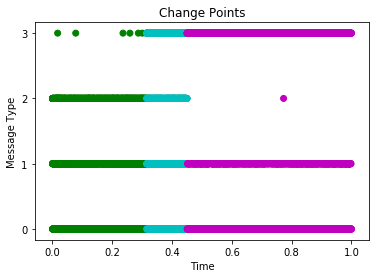

In [39]:
temp = pd.to_datetime(np.array(tseries['msg'].index))
temp1 = pd.to_timedelta(np.array(temp)).total_seconds()
a = temp1[0].astype(float)
temp1 = temp1-temp1[0]
b = temp1.max().astype(float)   
temp1 = temp1/temp1.max()
time = np.array(temp1)
col = np.array(range(len(time))).astype(str)
col[:changepointsInd[0]] = 'g'
col[changepointsInd[0]:changepointsInd[1]] = 'c'
col[changepointsInd[1]:] = 'm'
word = tseries['msg'].values.astype(int)
plt.figure(0)
plt.scatter(time,word,c=col)
plt.ylabel('Message Type')
plt.xlabel('Time')
plt.yticks([0,1,2,3])
plt.title('Change Points')
plt.savefig('chpt.png')

In [43]:
#compare the distribution with the true distribution
print('Event 2: ',0.5*abs(dist2-model.topic_word_[0]).sum())
print('Event 1: ',0.5*abs(dist1-model.topic_word_[1]).sum())

Event 2:  0.02351091328328077
Event 1:  0.018006223587556002


In [172]:
"""
vocabulary = 50

T = 60

numfaultevent = 10
numfaulttype = 3

(word,time,Y,Z) = generateData(vocabulary,T,numfaulttype,numfaultevent)
"""

'\nvocabulary = 50\n\nT = 60\n\nnumfaultevent = 10\nnumfaulttype = 3\n\n(word,time,Y,Z) = generateData(vocabulary,T,numfaulttype,numfaultevent)\n'

In [175]:
temp = pd.to_datetime(np.array(tseries['msg'].index))
#pd.to_timedelta(np.array(tseries['msg'].index))
temp1 = pd.to_timedelta(np.array(temp)).total_seconds()
temp1 = temp1-temp1[0]
temp1 = temp1/temp1.max()
temp1 = 0.8*(temp1)+0.1
time = np.array(temp1)
word = tseries['msg'].values.astype(int)
numfaultevent = 2
numfaulttype = 2
vocabulary = 4
Z = np.zeros(numfaultevent,int)

In [176]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  3 18:27:53 2016

@author: ssatpth2
"""

import numpy as np
import scipy.special
import scipy.stats
import scipy.spatial.distance

def betafunc(vec):
    g = [scipy.special.gammaln(vec[i]) for i in range(len(vec))]
    #check for overflow
    #print(np.sum(g) - scipy.special.gammaln(np.sum(vec)))
    return np.exp(np.sum(g) - scipy.special.gammaln(np.sum(vec)))

def betafuncln(vec):
    g = [scipy.special.gammaln(vec[i]) for i in range(len(vec))]
    #check for overflow
    return (np.sum(g) - scipy.special.gammaln(np.sum(vec)))

def mymultinomial(numexp, param):
    sample = np.zeros(numexp)
    for i in range(numexp):

        temp = np.random.multinomial(1, param)
        temp = np.where(temp == 1)
        temp = temp[0]
        sample[i] = temp[0]

    
    return sample.astype(int)

def betafit(sample,method):
    if method == 'MLE':
        (alpha,beta1) = scipy.stats.beta.fit(sample,floc = 0,fscale = 1)[0:2]
    if method == 'Moment':
        
        mean = np.mean(sample)
        var = np.var(sample)
        if var < mean*(1 - mean):
            alpha = mean**2*(1-mean)/var-mean
            beta1 = alpha*(1-mean)/mean
        else:
            print('samples for beta distribution are wrong')
        
    return (alpha,beta1)

def conditionalZ(j,time,word,Yhat,Zhat,alpha,gamma,countwords,countfault,numfaulttype,numfaultevent,timeparam):
    p = np.zeros(numfaulttype) # p[k] stores probability of having conditional Zhat[j] =k
    countfault[Zhat[j]] = countfault[Zhat[j]] - 1
    for i in range(len(time)):
        if Yhat[i] == j:
            countwords[word[i]][Zhat[j]] =  countwords[word[i]][Zhat[j]] - 1
    if np.min(countwords) <0 or np.min(countfault)<0:
        print('Count is < 0')
    for k in range(numfaulttype):
        # computing conditional Zhat[j] = k
        tempcountfault = np.copy(countfault)
        tempcountfault[k] = tempcountfault[k] + 1
        tempcountwords = np.copy(countwords)
        # counting nmber of words pointing to Zhat[j] or with Y[.] = j
        for i in range(len(time)):
            if Yhat[i] == j:
                tempcountwords[word[i]][k] = tempcountwords[word[i]][k] + 1


        # P(time,word,Y,Z) = P(Z)P(T,Y|Z)P(W|Y,Z)
        #computing P(Z)
        pz = betafuncln(alpha + tempcountfault) - betafuncln(alpha + countfault)
        # Computing P(W|Y,Z)
        val1 = betafuncln(gamma[k] + tempcountwords[:,k]) - betafuncln(gamma[k])
        val2 = betafuncln(gamma[k] + countwords[:,k]) - betafuncln(gamma[k])
        pw = val1 - val2


        # computing P(T,Y|Z)
        temptime = np.array([time[l] for l in range(len(Y)) if Yhat[l] == j]) # all times l sich that Y[l] = j
        if temptime.size < 2:
            pt = - 1000
        else:
            t_start = temptime[0]
            t_end = temptime[-1]
            temptime = temptime[1:-1]
            n = len(temptime)
            if n == 0:
                pt = scipy.stats.poisson.logpmf(0,100)
            else:
                temptime = (temptime - t_start)/(t_end - t_start) 
                pt = scipy.stats.poisson.logpmf(n,100)
                if np.isnan(pt):
                    print('pt is nan')
                pt = pt +  np.sum(   scipy.stats.beta.logpdf(temptime, timeparam[k][0], timeparam[k][1],loc =0,scale = 1)    )
                if np.isnan(pt) or np.isinf(pt):
                    print(temptime);print(np.min(temptime));print(np.max(temptime), timeparam[k][0], timeparam[k][1])
                    print(scipy.stats.beta.logpdf(temptime, timeparam[k][0], timeparam[k][1]));
                    print('pt is nan after log');
        # Computing p[k]
        if np.isinf(pz + pt + pw) or np.isnan(pz + pt + pw):
            print('stop here');print(pt);print(pw);print(pz);
        p[k] = pz + pt + pw
    if (np.isinf(p)).any() or (np.isnan(p)).any():
        print(p)
    p = p - np.max(p)
    if (np.isinf(p)).any() or (np.isnan(p)).any():
        print(p)
    p1 = np.exp(p)
    if (np.isinf(p1)).any() or (np.isnan(p1)).any():
        print(p1);print(p)
    p1 = p1/np.sum(p1)
    print(p1)
    sample = mymultinomial(1,p1)
    return sample[0]


def conditionalY(j,time,word,Yhat,Zhat,alpha,gamma,countwords,countfault,numfaulttype,numfaultevent,timeparam):
    p = np.zeros(numfaultevent) # p[k] stores probability of having conditional Yhat[j] =k
    countwords[word[j]][Zhat[Yhat[j]]] = countwords[word[j]][Zhat[Yhat[j]]] - 1
    Yhatorig = np.copy(Yhat)
    Yhatorig[j] = -1
    if np.min(countwords) <0 or np.min(countfault)<0:
        print('Count is < 0')
    for k in range(numfaultevent):
        # computing conditional Yhat[j] = k
        Yhat[j] = k
        tempcountwords = np.copy(countwords)

        tempcountwords[word[j]][Zhat[k]] = tempcountwords[word[j]][Zhat[k]] + 1 

        # P(time,word,Y,Z) = P(Z)P(T,Y|Z)P(W|Y,Z)
        # upon changing Y[j] P(Z) does not change
        # Computing P(W|Y,Z)
        eventtype = Zhat[k]
        # check if correct
        val1 = betafuncln(gamma[eventtype ] + tempcountwords[:,eventtype])
        val2 = betafuncln(gamma[eventtype ] + countwords[:,eventtype])
        #print(val1)
        #print(val2)
        pw = (val1 - val2)


        # computing P(T,Y|Z)
        pt = 0
        temptime = np.array([time[l] for l in range(len(Y)) if Yhatorig[l] == k])
        if temptime.size < 2:
            pt = - 1000
        else:
            t_start = temptime[0]
            t_end = temptime[-1]
            temptime = temptime[1:-1]
            n = len(temptime)
            if n == 0:
                pt = scipy.stats.poisson.logpmf(n,100)
            else:
                temptime = (temptime - t_start)/(t_end - t_start)
                pt = scipy.stats.poisson.logpmf(n,100)
                pt = pt - np.sum(np.log(scipy.stats.beta.pdf(temptime,timeparam[Zhat[k]][0],timeparam[Zhat[k]][1])))
                
        temptime = np.array([time[l] for l in range(len(Y)) if Yhat[l] == k])
        if temptime.size < 2:
            pt = - 1000
        else:
            t_start = temptime[0]
            t_end = temptime[-1]
            temptime = temptime[1:-1]
            n = len(temptime)
            if n == 0:
                pt = scipy.stats.poisson.pmf(0,100)
            else:
                temptime = (temptime - t_start)/(t_end - t_start)
                pt = scipy.stats.poisson.pmf(n,100)
                pt = pt + np.sum(scipy.stats.beta.logpdf(temptime,timeparam[Zhat[k]][0],timeparam[Zhat[k]][1],loc =0,scale = 1))
        # Computing p[k]
        p[k] = pt + pw
        if np.isinf(pt + pw) or np.isnan(pt + pw):
            print('stop here');print(pt);print(pw)
    if (np.isinf(p)).any() or (np.isnan(p)).any():
        print(p)
    p = p - np.max(p)
    if (np.isinf(p)).any() or (np.isnan(p)).any():
        print(p)
    p1 = np.exp(p)
    if (np.isinf(p1)).any() or (np.isnan(p1)).any():
        print(p);print(p1);
    p1 = p1/np.sum(p1)
    sample = mymultinomial(1,p1)
    return sample[0]


def updatetimeparam(time,Y,Z,timeparam):

    '''Using list!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'''
    sample = [[] for i in range(numfaulttype)]

    for i in range(numfaultevent):
        # compute prodcut of all times comming from this faultevent

        temptime = [time[l] for l in range(len(Y)) if Y[l] == i]
        if len(temptime)>2:
            t_start = temptime[0]
            t_end = temptime[-1]
            temptime = temptime[1:-1]
            temptime = [ (temptime[j] - t_start)/(t_end - t_start) for j in range(len(temptime))]
            sample[Z[i]].extend(temptime)


    for i in range(numfaulttype):
        if len(sample[i]):
            (timeparam[i][0],timeparam[i][1]) = betafit(sample[i],'MLE')

    return timeparam

def updateCounts(Yhat,Zhat,vocabulary,numfaulttype):
    countfault = np.array([np.count_nonzero(Zhat == i) for i in range(numfaulttype)])
    countwords = np.zeros([vocabulary,numfaulttype],int)
    for i in range(numfaulttype):
        countwords[:,i] = np.array([ np.count_nonzero( Zhat[Yhat[word == v ]] ==   i ) for v in range(vocabulary) ])
    
    return (countwords,countfault)


def generateData(V,T,numfaulttype,numfaultevent):

    alpha = np.random.uniform(0,1,numfaulttype)
    alpha = alpha/np.sum(alpha)
    alpha = np.random.dirichlet(alpha)
    print(alpha)
    Z = np.zeros(numfaultevent,int) 
    lambdarate = np.array([100 for i in range(numfaulttype)])

    timeparam = np.zeros([numfaulttype, 2])
    gamma = np.zeros([numfaulttype, V])
    for i in range(numfaulttype):
        gamma[i] = np.random.uniform(0,1,V)
        gamma[i] = gamma[i]/np.sum(gamma[i])
        gamma[i] = np.random.dirichlet(gamma[i]) #sampling from Dirichlet distribution
        print((gamma[i]).max())
        timeparam[i] = np.concatenate( (  np.random.uniform(1,5,1), np.random.uniform(1,5,1) ) )

    word = []
    time = []
    times = [[] for i in range(numfaultevent)]
    words = [[] for i in range(numfaultevent)]
    n_times = np.zeros(numfaultevent,int)
    
    for i in range(numfaultevent):
        faultevent = mymultinomial(1,alpha)
        faultevent = faultevent[0]
        Z[i] = faultevent
        #faultevent has the type of faultevent stored in it
        [temp1,temp2] = np.random.uniform(0,T,2)
        t_start = np.minimum(temp1,temp2)
        t_end = np.maximum(temp1,temp2)
        n_times[i] = np.random.poisson(lambdarate[faultevent])
        times[i] = sorted([t_start + (t_end - t_start)*np.random.beta(timeparam[faultevent][0],timeparam[faultevent][1]) for j in range(n_times[i])])
        times[i] = [t_start] + times[i] + [t_end]
        n_times[i] = n_times[i] + 2
        words[i] = mymultinomial(n_times[i], gamma[faultevent])
        word.extend(words[i])
        time.extend(times[i])

    ind = np.argsort(time)
    time = np.array(time)
    word = np.array(word)

    time = time[ind]
    word = word[ind]
    Y = np.zeros(len(time),int)
    for i in range(len(time)):
        val = time[i]
        temp = [j for j in range(numfaultevent) if val in times[j]]
        Y[i] = temp[0] # stores which faultevet does time[i] belong to 

    return (word,time,Y,Z)

#myvar = times[-1]
#myvar = np.array(myvar)
#myvar = (myvar[1:-1] - myvar[0]) /(myvar[-1]  - myvar[0])
#betafit(myvar,'MLE')

#### sampling algorithm
niter = 5

#initialize randomly Y and Z
Zhat = np.random.randint(low = 0, high = numfaulttype, size = numfaultevent)
Yhat = np.random.randint(low = 0, high = len(Z), size = len(word))
#(_,_,Yhat,Zhat) = generateData(vocabulary,totalTime,numfaulttype,numfaultevent)
#Yhat = Yhat.astype(int)
#Zhat = Zhat.astype(int)
#initialize the counts
countfault = np.array([np.count_nonzero(Zhat == i) for i in range(numfaulttype)])
countwords = np.zeros([vocabulary,numfaulttype],int)
for i in range(numfaulttype):
    countwords[:,i] = np.array([ np.count_nonzero( Zhat[Yhat[word == v ]] ==   i ) for v in range(vocabulary) ])

alphahat = np.random.uniform(0,1,numfaulttype)#params of dirichlet distribution
alphahat = alphahat/np.sum(alphahat)
timeparamhat = np.zeros([numfaulttype,2])
gammahat = np.zeros([numfaulttype,vocabulary])#params of dirichlet distribution
for i in range(numfaulttype):
    gammahat[i] = np.random.uniform(0,1,vocabulary)
    gammahat[i] = gammahat[i]/np.sum(gammahat[i])
    timeparamhat[i] = np.concatenate( (  np.random.uniform(1,5,1), np.random.uniform(1,5,1) ) )



for i in range(niter):
    Yhatprev = np.copy(Yhat)
    Zhatprev = np.copy(Zhat)
    print(i)

    #Update Y_j
    for j in range(len(time)):
        #temp = conditionalY(j,time,word,Yhat,Zhat,alphahat,gammahat,countwords,countfault,numfaulttype,numfaultevent,timeparamhat)
        Yhat[j] = conditionalY(j,time,word,Yhat,Zhat,alphahat,gammahat,countwords,countfault,numfaulttype,numfaultevent,timeparamhat)
        (countwords,countfault) = updateCounts(Yhat,Zhat,vocabulary,numfaulttype)
    #Update Z_j
    for j in range(numfaultevent):
        Zhat[j] = conditionalZ(j,time,word,Yhat,Zhat,alphahat,gammahat,countwords,countfault,numfaulttype,numfaultevent,timeparamhat)
        (countwords,countfault) = updateCounts(Yhat,Zhat,vocabulary,numfaulttype)
    #update the timeparamhat
    timeparamhat = updatetimeparam(time,Yhat,Zhat,timeparamhat)
    
    print( scipy.spatial.distance.hamming(Yhatprev,Yhat) )
    print( scipy.spatial.distance.hamming(Zhatprev,Zhat) )
print( scipy.spatial.distance.hamming(Y,Yhat) )
#print( scipy.spatial.distance.hamming(Z,Zhat) )
#print(beta)

0
stop here
-inf
-1.4007419812260196
[-4387.28557419           -inf]
[  0. -inf]
stop here
-inf
-1.4007419812260196
[-4402.34391983           -inf]
[  0. -inf]


C:\Users\siddp\Anaconda3\lib\site-packages\ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in log


stop here
-inf
-1.4007419812260196
[-4417.40226548           -inf]
[  0. -inf]
stop here
-inf
-1.362412828952074
[-4445.91560751           -inf]
[  0. -inf]
[1. 0.]
[1. 0.]
0.4535
1.0
1
stop here
-inf
-1.4007863431615988
[        -inf 111.07874265]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 111.25448137]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 111.78236177]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 112.17295403]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 113.37454081]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 113.75315793]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 114.82150551]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 116.07082934]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 116.26457266]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[       -inf 119.2869598]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 119.83841334]
[-i

[        -inf 219.46934749]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 219.62858121]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 220.12920281]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 221.53641143]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 221.85389687]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 223.63511269]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 225.33556974]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 225.80863227]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 226.16191966]
[-inf   0.]
stop here
-inf
-1.4007863431615988
[        -inf 226.59601992]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 227.89099837]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 228.03267774]
[-inf   0.]
stop here
-inf
-1.3777458830008982
[        -inf 228.50307958]
[-inf   0.]
stop here
-inf
-1.3625635091302684
[        -inf 228.5182619

In [180]:
Yhat[Yhat==0]

array([], dtype=int32)

In [156]:
print(timeparamhat)

[[1.09091505 1.40292071]
 [2.15593533 4.0064497 ]]
